In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16
from keras.preprocessing import image
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import os

Text(0.5, 1.0, 'Content Image')

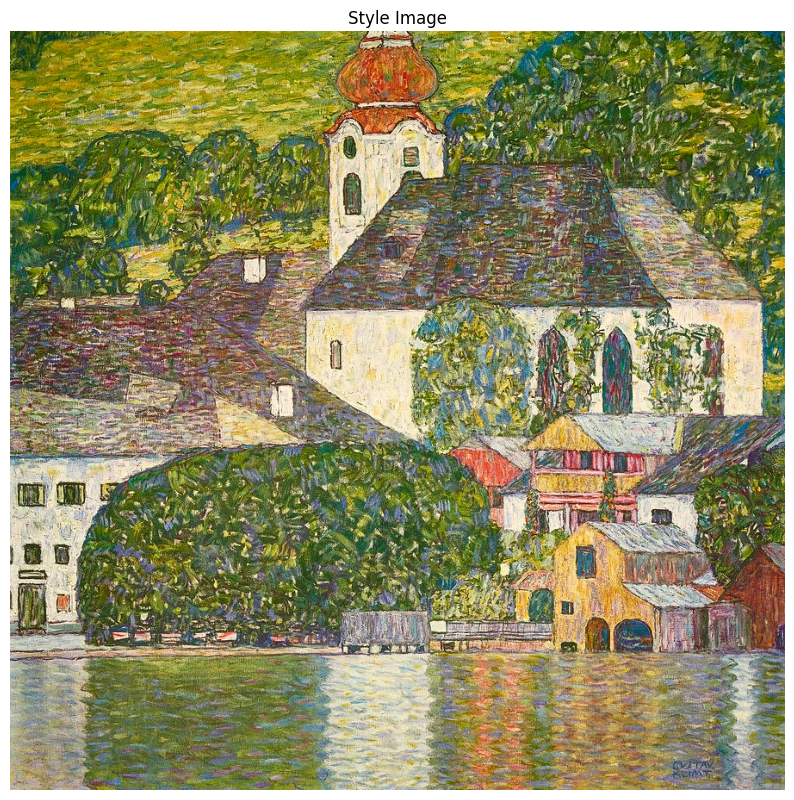

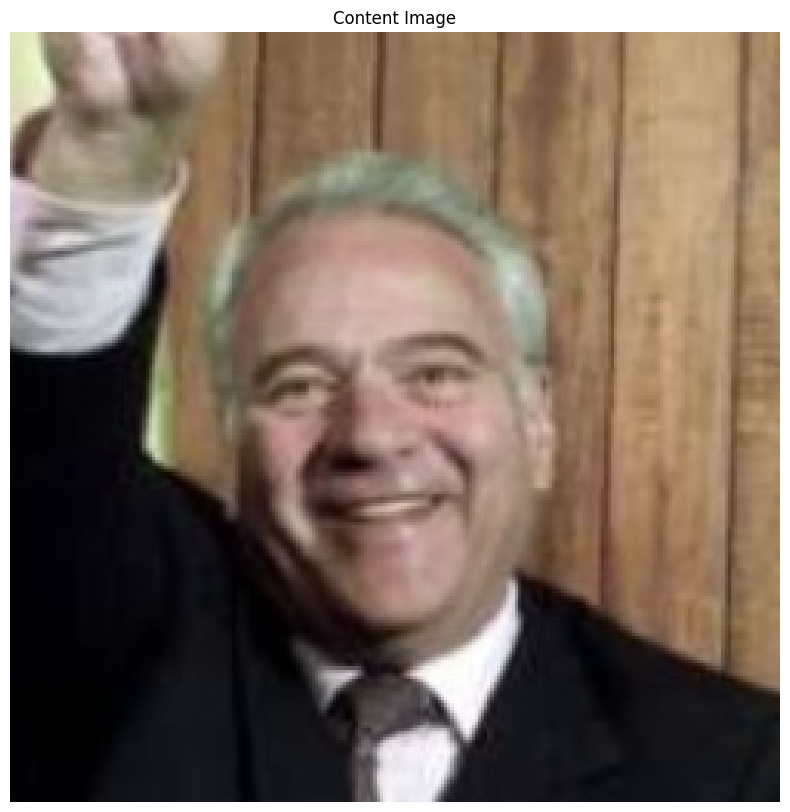

In [24]:
figure = plt.figure(figsize=(10, 10))
style_img_1 = cv2.imread('/content/drive/MyDrive/DL_Project/2001717111670_.pic.jpg')
style_img_1 = cv2.cvtColor(style_img_1, cv2.COLOR_BGR2RGB)
plt.imshow(style_img_1)
plt.axis('off')
plt.title('Style Image')

figure2 = plt.figure(figsize=(10, 10))
content_img = cv2.imread('/content/drive/MyDrive/DL_Project/images/Gonzalo_Sanchez_de_Lozada_0005.jpg')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
plt.imshow(content_img)
plt.axis('off')
plt.title('Content Image')

In [25]:
# Directory paths
content_path = '/content/drive/MyDrive/DL_Project/images/Gonzalo_Sanchez_de_Lozada_0005.jpg'
style_path = '/content/drive/MyDrive/DL_Project/2001717111670_.pic.jpg'

# Preprocess the image to fit VGG16 input
def preprocess_image(image_path, target_size=(200, 200)):
    img = image.load_img(image_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# Deprocess the image to make it viewable
def deprocess_image(x, target_size=(200, 200)):
    x = x.reshape((target_size[0], target_size[1], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return Image.fromarray(x)

# Extract features of style and content layers
style_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layer_name = "block5_conv2"

# Define the TensorFlow function to calculate content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Define the TensorFlow function to calculate the style loss
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 200 * 200
    return tf.reduce_sum(tf.square(S - C)) / (channels * (3 ** 2) * (size ** 2))

# Compute total variation loss to encourage spatial smoothness
def total_variation_loss(x):
    a = tf.square(x[:, :200 - 1, :200 - 1, :] - x[:, 1:, :200 - 1, :])
    b = tf.square(x[:, :200 - 1, :200 - 1, :] - x[:, :200 - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 0.025

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [26]:
# Load VGG16 model without the top layer and set trainable to false
model = vgg16.VGG16(weights='imagenet', include_top=False)
model.trainable = False

# Dictionary of layer tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [27]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [28]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=500, decay_rate=0.96
    )
)

# Load style images
style_reference_image = preprocess_image(style_path)

base_image = preprocess_image(content_path)
combination_image = tf.Variable(preprocess_image(content_path))

print(base_image.shape)
print(style_reference_image.shape)
print(combination_image.shape)

(1, 200, 200, 3)
(1, 200, 200, 3)
(1, 200, 200, 3)


In [29]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [30]:
losses = []
iter = []
result_prefix = "neural_style_transfer_generated"
iterations = 10000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    losses.append(loss)
    iter.append(i)
    if i % 1000 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
    if i == iterations:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        img.save(result_prefix + "_at_iteration_%d.png" % i)

Iteration 1000: loss=1660.60
Iteration 2000: loss=1570.70
Iteration 3000: loss=1532.71
Iteration 4000: loss=1511.21
Iteration 5000: loss=1497.31
Iteration 6000: loss=1487.53
Iteration 7000: loss=1480.40
Iteration 8000: loss=1474.85
Iteration 9000: loss=1470.54
Iteration 10000: loss=1466.92


Text(0.5, 1.0, 'Content Image')

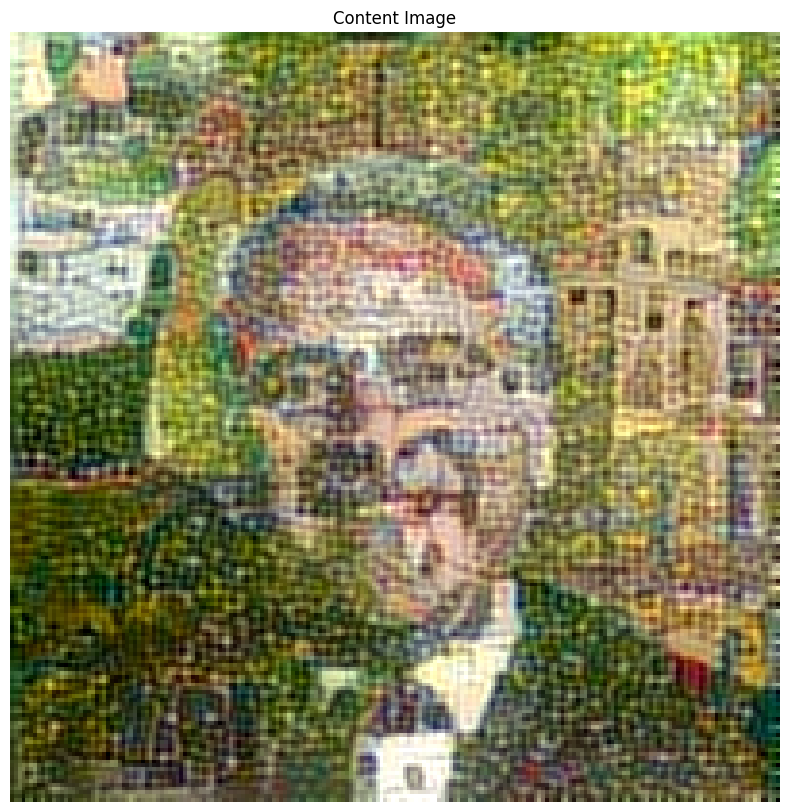

In [31]:
figure2 = plt.figure(figsize=(10, 10))
content_img = cv2.imread('neural_style_transfer_generated_at_iteration_10000.png')
content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB)
plt.imshow(content_img)
plt.axis('off')
plt.title('Content Image')